# Machine Learning in Python - MNIST Fashion

## Data Prep

### Lots of Imports

To build predictive models in Python we use a set of libraries that are imported here. In particular **pandas** and **sklearn** are particularly important.

In [2]:
import os
import subprocess
from IPython.display import display, HTML, Image
import io
from operator import itemgetter

from TAS_Python_Utilities import data_viz
from TAS_Python_Utilities import data_viz_target
from TAS_Python_Utilities import visualize_tree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from random import randint
from scipy.misc import toimage

from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn import neural_network

%matplotlib inline
#%qtconsole

### Setup - IMPORTANT

Take only a sample of the dataset for fast testing

In [3]:
data_sampling_rate = 0.1

Setup the number of folds for all grid searches (should be 5 - 10)

In [4]:
cv_folds = 2

Set up a dictionary to store simple model perofrmance comparions

In [5]:
model_test_accuracy_comparisons = dict()
model_valid_accuracy_comparisons = dict()
model_tuned_params_list = dict()

### Load & Partition Data

Load the dataset and explore it.

In [6]:
dataset = pd.read_csv('fashion-mnist_train.csv')
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everyhting runs smoothly
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
3896,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38730,4,0,0,0,0,0,0,0,0,0,...,93,60,0,0,175,154,90,0,0,0
4955,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58804,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22012,2,0,0,0,0,0,0,0,0,0,...,4,0,0,186,194,139,0,0,0,0


Examine the distribution of the two classes

In [7]:
dataset["label"].value_counts()

2    633
6    632
7    614
4    613
0    599
1    592
8    591
3    586
9    576
5    564
Name: label, dtype: int64

无sample情况下每个都有6000

In [8]:
if(dataset.select_dtypes(include=[np.number]).shape[1] > 0):
    display(dataset.select_dtypes(include=[np.number]).describe())
if(dataset.select_dtypes(include=[np.object]).shape[1] > 0):
    display(dataset.select_dtypes(include=[np.object]).describe())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,...,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.00000,6000.000000,6000.000000,6000.00000
mean,4.481667,0.000500,0.002500,0.018667,0.052333,0.156167,0.354333,0.651333,2.037667,5.624500,...,34.438833,22.808833,16.043833,18.516333,23.572167,18.445833,8.39100,2.446667,0.799833,0.09900
std,2.861240,0.022357,0.067041,0.199979,1.033653,2.656179,5.452804,7.120315,13.486594,24.010878,...,57.494857,48.358305,41.134312,44.421676,52.694398,45.566455,28.87633,16.208165,9.114436,3.20212
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
50%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,57.000000,7.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.00000
max,9.000000,1.000000,3.000000,5.000000,56.000000,116.000000,202.000000,198.000000,194.000000,232.000000,...,253.000000,255.000000,241.000000,249.000000,255.000000,255.000000,232.00000,226.000000,203.000000,170.00000


In [9]:
# Check for presence of missing values
print("Missing Values")
print(dataset.isnull().sum())

Missing Values
label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
pixel6      0
pixel7      0
pixel8      0
pixel9      0
pixel10     0
pixel11     0
pixel12     0
pixel13     0
pixel14     0
pixel15     0
pixel16     0
pixel17     0
pixel18     0
pixel19     0
pixel20     0
pixel21     0
pixel22     0
pixel23     0
pixel24     0
pixel25     0
pixel26     0
pixel27     0
pixel28     0
pixel29     0
           ..
pixel755    0
pixel756    0
pixel757    0
pixel758    0
pixel759    0
pixel760    0
pixel761    0
pixel762    0
pixel763    0
pixel764    0
pixel765    0
pixel766    0
pixel767    0
pixel768    0
pixel769    0
pixel770    0
pixel771    0
pixel772    0
pixel773    0
pixel774    0
pixel775    0
pixel776    0
pixel777    0
pixel778    0
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64


In [ ]:
# Visualise fields
#data_viz(dataset)

In [ ]:
# Visualise fields in relation to target
#data_viz_target(dataset, "label")

Isolate the descriptive features we are interested in

In [10]:
X = dataset[dataset.columns[1:]]
Y = np.array(dataset["label"])

Display some of the images

[ 798 ]  Sandal


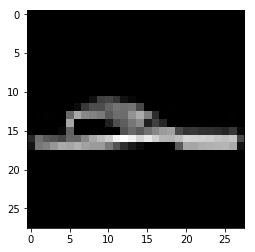

[ 2544 ]  Shirt


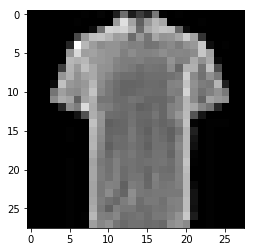

[ 1241 ]  Pullover


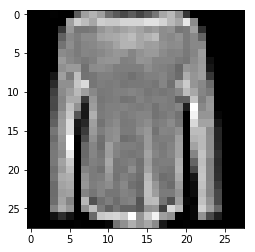

[ 143 ]  Coat


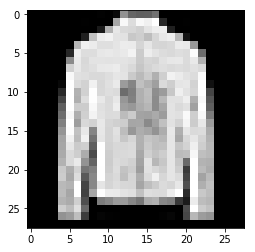

[ 2131 ]  Sandal


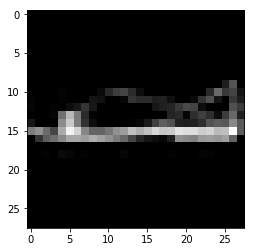

[ 4625 ]  Bag


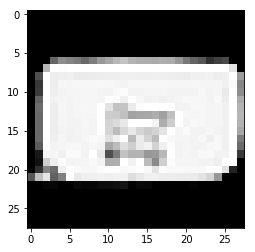

[ 4132 ]  Pullover


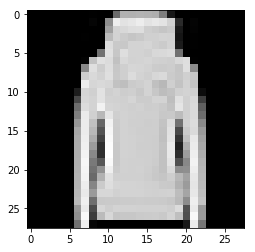

[ 492 ]  Bag


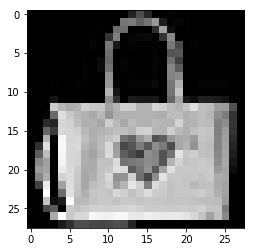

[ 3307 ]  Dress


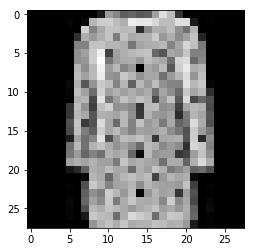

In [17]:
# create a sample of images from the dataset
for i in range(0, 9):
    i_rand = randint(0, X.shape[0])

    print("[", i_rand, "] ", classes[Y[i_rand]])
    two_d = (X.iloc[i_rand].values.reshape(28, 28))
    pyplot.imshow(two_d, cmap='gray')
    pyplot.show()


Normalise the data (important for some models)

In [12]:
X = X/255

Split the data into a **training set**, a **vaidation set**, and a **test set**

In [18]:
X_train_plus_valid, X_test, y_train_plus_valid, y_test \
    = train_test_split(X, Y, random_state=0, \
                                    train_size = 0.7)

X_train, X_valid, y_train, y_valid \
    = train_test_split(X_train_plus_valid, \
                                        y_train_plus_valid, \
                                        random_state=0, \
                                        train_size = 0.5/0.7)

## Building Simple Models

### A Very Simple Decision Tree

Train a decision tree

In [19]:
my_tree = tree.DecisionTreeClassifier(criterion="entropy")
my_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Visualise the decision tree so we can see what it is doing!

In [ ]:
#feature_names = list(X_train.columns)
#visualize_tree(my_tree, feature_names, fileName='dt_over.png')
#Image(filename='dt_over.png') 

### Evaluating Model Performance

Assess the performance of the decision tree on the training set

In [20]:
# Make a set of predictions for the training data
y_pred = my_tree.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_train), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       277
          1       1.00      1.00      1.00       310
          2       1.00      1.00      1.00       323
          3       1.00      1.00      1.00       293
          4       1.00      1.00      1.00       323
          5       1.00      1.00      1.00       252
          6       1.00      1.00      1.00       332
          7       1.00      1.00      1.00       303
          8       1.00      1.00      1.00       299
          9       1.00      1.00      1.00       288

avg / total       1.00      1.00      1.00      3000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,277,0,0,0,0,0,0,0,0,0,277
1,0,310,0,0,0,0,0,0,0,0,310
2,0,0,323,0,0,0,0,0,0,0,323
3,0,0,0,293,0,0,0,0,0,0,293
4,0,0,0,0,323,0,0,0,0,0,323
5,0,0,0,0,0,252,0,0,0,0,252
6,0,0,0,0,0,0,332,0,0,0,332
7,0,0,0,0,0,0,0,303,0,0,303
8,0,0,0,0,0,0,0,0,299,0,299


Assess the performance of the tree on the validation dataset

In [21]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Simple Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_valid, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.701666666667
             precision    recall  f1-score   support

          0       0.73      0.64      0.68       141
          1       0.89      0.89      0.89       111
          2       0.65      0.65      0.65       141
          3       0.74      0.76      0.75       106
          4       0.54      0.53      0.54       116
          5       0.76      0.79      0.78       117
          6       0.39      0.48      0.43       128
          7       0.79      0.75      0.77       113
          8       0.86      0.77      0.82       124
          9       0.79      0.82      0.80       103

avg / total       0.71      0.70      0.70      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,90,2,3,8,2,4,32,0,0,0,141
1,0,99,1,6,1,0,1,0,1,2,111
2,4,0,91,2,18,0,24,0,2,0,141
3,4,5,4,81,5,1,4,0,1,1,106
4,0,3,22,5,61,0,23,0,1,1,116
5,1,0,0,0,2,93,2,9,4,6,117
6,23,1,16,5,17,0,62,0,4,0,128
7,0,0,0,0,0,16,0,85,0,12,113
8,1,1,2,1,6,1,10,5,96,1,124


Assess the performance of the tree on the validation dataset

In [22]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Simple Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
# print(metrics.confusion_matrix(y_test, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.739444444444
             precision    recall  f1-score   support

          0       0.68      0.66      0.67       181
          1       0.92      0.91      0.91       171
          2       0.58      0.56      0.57       169
          3       0.76      0.76      0.76       187
          4       0.59      0.59      0.59       174
          5       0.85      0.87      0.86       195
          6       0.44      0.47      0.45       172
          7       0.83      0.84      0.84       198
          8       0.84      0.83      0.83       168
          9       0.88      0.88      0.88       185

avg / total       0.74      0.74      0.74      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,119,4,11,13,2,1,27,0,4,0,181
1,2,155,2,7,2,0,3,0,0,0,171
2,4,0,94,4,32,0,33,0,2,0,169
3,9,8,1,143,10,1,13,0,2,0,187
4,2,1,34,8,102,0,20,0,7,0,174
5,0,0,0,0,0,169,1,17,0,8,195
6,35,0,18,10,21,1,81,0,6,0,172
7,0,0,0,0,0,19,0,167,0,12,198
8,3,0,3,2,3,1,8,6,139,3,168


### Less Overiftted Decision Tree

Train a decision tree, setting min samples per leaf to a sensible value

In [23]:
my_tree = tree.DecisionTreeClassifier(criterion="entropy", min_samples_split = 200)
my_tree = my_tree.fit(X_train,y_train)

Visualise the decision tree so we can see what it is doing!

In [ ]:
# visualise the decision tree
#feature_names = list(X_train.columns)
#visualize_tree(my_tree, feature_names, fileName="dt_under.png")
#Image(filename='dt_under.png') 

Assess the performance of the decision tree on the **training set**

In [24]:
# Make a set of predictions for the training data
y_pred = my_tree.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_train), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.749
             precision    recall  f1-score   support

          0       0.83      0.72      0.77       277
          1       0.96      0.91      0.94       310
          2       0.59      0.72      0.65       323
          3       0.70      0.82      0.75       293
          4       0.72      0.46      0.56       323
          5       0.83      0.85      0.84       252
          6       0.50      0.52      0.51       332
          7       0.91      0.81      0.86       303
          8       0.77      0.84      0.80       299
          9       0.80      0.90      0.85       288

avg / total       0.76      0.75      0.75      3000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,199,2,4,18,1,0,40,0,13,0,277
1,0,282,4,18,0,2,3,0,1,0,310
2,3,0,234,3,37,1,37,0,8,0,323
3,1,8,10,240,1,8,23,0,2,0,293
4,0,0,84,30,148,0,46,0,15,0,323
5,0,0,0,0,0,215,10,5,5,17,252
6,35,0,58,28,18,0,172,0,21,0,332
7,0,0,0,0,0,14,0,245,1,43,303
8,3,1,3,8,0,16,9,4,252,3,299


Assess the performance of the decision tree on the **validation set**

In [25]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Better Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True, dropna = False)

Accuracy: 0.671666666667
             precision    recall  f1-score   support

          0       0.80      0.64      0.71       141
          1       0.90      0.82      0.86       111
          2       0.64      0.68      0.66       141
          3       0.54      0.71      0.61       106
          4       0.51      0.35      0.42       116
          5       0.72      0.75      0.74       117
          6       0.44      0.51      0.47       128
          7       0.77      0.62      0.69       113
          8       0.76      0.83      0.79       124
          9       0.71      0.84      0.77       103

avg / total       0.68      0.67      0.67      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,90,0,4,19,0,1,23,0,4,0,141
1,0,91,2,8,2,0,4,0,4,0,111
2,2,0,96,0,19,0,21,0,3,0,141
3,0,9,9,75,3,2,7,0,1,0,106
4,1,0,24,18,41,0,24,0,8,0,116
5,0,0,0,0,1,88,0,10,8,10,117
6,19,0,14,15,12,0,65,0,3,0,128
7,0,0,0,0,0,18,0,70,0,25,113
8,0,1,1,3,2,7,3,3,103,1,124


In [26]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Better Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True, dropna = False)

Accuracy: 0.695555555556
             precision    recall  f1-score   support

          0       0.79      0.61      0.69       181
          1       0.95      0.87      0.91       171
          2       0.52      0.59      0.55       169
          3       0.67      0.79      0.72       187
          4       0.59      0.39      0.47       174
          5       0.77      0.87      0.82       195
          6       0.39      0.44      0.42       172
          7       0.84      0.73      0.78       198
          8       0.68      0.80      0.73       168
          9       0.80      0.83      0.81       185

avg / total       0.70      0.70      0.69      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,111,1,4,15,1,0,37,0,12,0,181
1,0,148,2,18,1,0,2,0,0,0,171
2,1,0,100,0,29,0,29,0,10,0,169
3,2,5,8,148,1,4,18,0,1,0,187
4,0,0,44,23,67,0,23,0,17,0,174
5,0,0,0,0,0,170,1,8,4,12,195
6,25,1,33,15,14,0,76,0,8,0,172
7,0,0,0,0,0,27,0,145,1,25,198
8,1,0,1,3,1,15,7,4,134,2,168


## Choosing Parameters Using a Grid Search

Use a cross validation to perfrom an evaluation

In [27]:
my_tree = tree.DecisionTreeClassifier(max_depth = 12)
scores = cross_val_score(my_tree, X_train_plus_valid, y_train_plus_valid, cv=10)
print(scores)

[ 0.71226415  0.68483412  0.7535545   0.73634204  0.74761905  0.70714286
  0.76372315  0.72792363  0.78229665  0.71807229]


An alternative to using post pruning explicitly is to use a grid search through a large set of possible parameters. Here we try depths between 3 and 20 and different limits on the minimum number of samples per split.

In [34]:
# Set up the parameter grid to seaerch
param_grid ={'criterion': ['gini', "entropy"], \
             'max_depth': list(range(3, 50, 3)), \
             'min_samples_split': [200]}

# Perform the search
my_tuned_tree = GridSearchCV(tree.DecisionTreeClassifier(), \
                                param_grid, cv=cv_folds, verbose = 2, \
                            return_train_score=True)
my_tuned_tree.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
display(my_tuned_tree.best_params_)
model_tuned_params_list["Tuned Tree"] = my_tuned_tree.best_params_
display(my_tuned_tree.best_score_)
display(my_tuned_tree.cv_results_)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=6, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=6, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=6, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=6, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=9, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=9, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=9, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=9, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=12, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=12, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=12, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=12, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=15, min_samples_split=200 ...........

[CV]  criterion=entropy, max_depth=42, min_samples_split=200, total=   0.6s
[CV] criterion=entropy, max_depth=42, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=42, min_samples_split=200, total=   0.6s
[CV] criterion=entropy, max_depth=45, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=45, min_samples_split=200, total=   0.5s
[CV] criterion=entropy, max_depth=45, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=45, min_samples_split=200, total=   0.5s
[CV] criterion=entropy, max_depth=48, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=48, min_samples_split=200, total=   0.5s
[CV] criterion=entropy, max_depth=48, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=48, min_samples_split=200, total=   0.5s


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   28.2s finished


Best parameters set found on development set:


{'criterion': 'gini', 'max_depth': 27, 'min_samples_split': 200}

0.68142857142857138

{'mean_fit_time': array([ 0.20968592,  0.31808448,  0.32249248,  0.32105637,  0.33199704,
         0.33212149,  0.34387219,  0.35148787,  0.33465493,  0.32421494,
         0.35487437,  0.32166505,  0.34316885,  0.33243656,  0.34130645,
         0.34283841,  0.32045901,  0.51895392,  0.58753002,  0.57786   ,
         0.54409587,  0.53961909,  0.53905809,  0.56862342,  0.54646146,
         0.52564037,  0.53155398,  0.53497696,  0.56386638,  0.57064545,
         0.53084052,  0.52977896]),
 'mean_score_time': array([ 0.00249815,  0.00293946,  0.00255394,  0.00234902,  0.00270915,
         0.00267851,  0.00341845,  0.00253522,  0.00239706,  0.00237751,
         0.00318062,  0.00295532,  0.00312257,  0.00255692,  0.00249898,
         0.00360692,  0.00236917,  0.00228143,  0.00294745,  0.00256765,
         0.0034796 ,  0.00255048,  0.00275445,  0.00296557,  0.00251734,
         0.00283718,  0.00288796,  0.00294101,  0.00285363,  0.00238156,
         0.00241864,  0.00272608]),
 'mean_test_scor

Evaluate the performance of the tuned tree

In [33]:
# Make a set of predictions for the test data
y_pred = my_tuned_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.69
             precision    recall  f1-score   support

          0       0.82      0.59      0.68       181
          1       0.83      0.88      0.85       171
          2       0.58      0.49      0.53       169
          3       0.77      0.66      0.71       187
          4       0.51      0.52      0.52       174
          5       0.70      0.87      0.77       195
          6       0.35      0.52      0.42       172
          7       0.81      0.78      0.79       198
          8       0.85      0.72      0.78       168
          9       0.89      0.82      0.85       185

avg / total       0.71      0.69      0.70      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,106,3,12,7,1,8,41,0,3,0,181
1,0,151,1,10,2,0,5,0,2,0,171
2,5,1,83,0,49,1,30,0,0,0,169
3,5,10,3,123,7,4,35,0,0,0,187
4,0,9,12,10,91,1,46,0,5,0,174
5,0,0,0,0,0,170,1,21,2,1,195
6,12,6,26,9,23,4,90,0,2,0,172
7,0,0,0,0,0,24,0,155,1,18,198
8,1,3,5,1,3,24,9,1,121,0,168


Visualise the tree

In [35]:
best_tree = tree.DecisionTreeClassifier(min_samples_split=200, criterion='gini', max_depth=8)
best_tree = best_tree.fit(X_train, y_train)

# visualise the decision tree
#feature_names = list(X_train.columns)
#visualize_tree(best_tree, feature_names, 'dt_tuned.png')
#Image(filename='dt_tuned.png') 

## Comparing Models

We can easily use the same patterns to train other types of models.

#### Random Forests

Train and evaluate a simple model 

In [36]:
# Do the same job with random forests
my_model = ensemble.RandomForestClassifier(n_estimators=300, \
                                           max_features = 3,\
                                           min_samples_split=200)
my_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [37]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Random Forest"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.723333333333
             precision    recall  f1-score   support

          0       0.74      0.73      0.73       141
          1       0.92      0.86      0.89       111
          2       0.69      0.74      0.72       141
          3       0.60      0.85      0.70       106
          4       0.56      0.60      0.58       116
          5       0.93      0.59      0.72       117
          6       0.50      0.26      0.34       128
          7       0.70      0.84      0.76       113
          8       0.90      0.94      0.92       124
          9       0.73      0.88      0.80       103

avg / total       0.73      0.72      0.71      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,103,1,2,22,0,0,8,0,5,0,141
1,1,96,8,5,1,0,0,0,0,0,111
2,0,0,105,0,22,0,12,0,2,0,141
3,2,6,2,90,2,0,3,0,1,0,106
4,0,1,18,17,70,0,10,0,0,0,116
5,0,0,0,0,0,69,0,30,2,16,117
6,34,0,16,12,29,1,33,0,3,0,128
7,0,0,0,0,0,1,0,95,0,17,113
8,0,0,1,4,0,2,0,1,116,0,124


Choose parameters using a grid search

In [38]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(100, 501, 50)), 'max_features': list(range(2, 10, 2)), 'min_samples_split': [200] }
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.RandomForestClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned Random Forest"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV] max_features=2, min_samples_split=200, n_estimators=100 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=100, total=   0.3s
[CV] max_features=2, min_samples_split=200, n_estimators=100 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  max_features=2, min_samples_split=200, n_estimators=100, total=   0.2s
[CV] max_features=2, min_samples_split=200, n_estimators=150 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=150, total=   0.4s
[CV] max_features=2, min_samples_split=200, n_estimators=150 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=150, total=   0.4s
[CV] max_features=2, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=200, total=   0.5s
[CV] max_features=2, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=200, total=   0.6s
[CV] max_features=2, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=250, total=   0.6s
[CV] max_features=2, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=2, min_samples_split=200, n_estimators=250, total=   1.1s
[CV] max_features=2, min_samples_sp

[CV]  max_features=8, min_samples_split=200, n_estimators=150, total=   0.6s
[CV] max_features=8, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=200, total=   0.7s
[CV] max_features=8, min_samples_split=200, n_estimators=200 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=200, total=   0.7s
[CV] max_features=8, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=250, total=   0.9s
[CV] max_features=8, min_samples_split=200, n_estimators=250 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=250, total=   0.9s
[CV] max_features=8, min_samples_split=200, n_estimators=300 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=300, total=   1.2s
[CV] max_features=8, min_samples_split=200, n_estimators=300 .........
[CV]  max_features=8, min_samples_split=200, n_estimators=300, total=   1.2s
[CV] max_features=8, min_samples_sp

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  1.2min finished


Best parameters set found on development set:
{'max_features': 8, 'min_samples_split': 200, 'n_estimators': 450}
0.74619047619


In [39]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Random Forest"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.802222222222
             precision    recall  f1-score   support

          0       0.73      0.77      0.75       181
          1       0.99      0.92      0.95       171
          2       0.68      0.71      0.70       169
          3       0.68      0.88      0.77       187
          4       0.63      0.66      0.65       174
          5       0.96      0.90      0.93       195
          6       0.65      0.34      0.45       172
          7       0.90      0.89      0.90       198
          8       0.89      0.94      0.92       168
          9       0.89      0.96      0.92       185

avg / total       0.80      0.80      0.80      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,139,2,6,24,1,0,5,0,4,0,181
1,0,158,3,10,0,0,0,0,0,0,171
2,1,0,120,0,34,0,11,0,3,0,169
3,10,0,1,165,5,0,6,0,0,0,187
4,0,0,22,25,115,0,9,0,3,0,174
5,0,0,0,0,0,175,0,12,1,7,195
6,40,0,24,16,25,0,59,0,8,0,172
7,0,0,0,0,0,5,0,177,0,16,198
8,1,0,0,4,2,2,1,0,158,0,168


#### Bagging

Train and evaluate a simple model 

In [41]:
# Do the same job with random forests
my_model = ensemble.BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf = 50), \
                                      n_estimators=10)
my_model.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [42]:
# Make a set of predictions for the validation data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Bagging"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.724166666667
             precision    recall  f1-score   support

          0       0.79      0.72      0.75       141
          1       0.94      0.82      0.88       111
          2       0.67      0.70      0.68       141
          3       0.58      0.85      0.69       106
          4       0.56      0.66      0.61       116
          5       0.79      0.72      0.75       117
          6       0.62      0.38      0.47       128
          7       0.77      0.72      0.74       113
          8       0.87      0.88      0.88       124
          9       0.74      0.88      0.81       103

avg / total       0.73      0.72      0.72      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,101,1,7,20,1,1,4,0,6,0,141
1,0,91,7,10,0,0,2,0,1,0,111
2,0,0,98,1,34,0,6,0,2,0,141
3,0,2,6,90,5,1,2,0,0,0,106
4,0,1,8,16,76,0,13,0,2,0,116
5,0,0,0,0,0,84,0,16,3,14,117
6,26,1,19,14,18,0,48,0,2,0,128
7,0,0,0,0,0,14,0,81,0,18,113
8,0,1,2,4,1,3,2,2,109,0,124


Choose parameters using a grid search

In [43]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(50, 501, 50)),
  'base_estimator': [tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 200)]}
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.BaggingClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned Bagging"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=50 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=50, total=   7.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=50, total=   7.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=100 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
        

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=350, total=  52.1s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=400 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
       

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 14.5min finished


Best parameters set found on development set:
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), 'n_estimators': 300}
0.55119047619


In [44]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Bagging"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.692222222222
             precision    recall  f1-score   support

          0       0.73      0.70      0.72       181
          1       0.95      0.87      0.91       171
          2       0.55      0.59      0.57       169
          3       0.66      0.84      0.74       187
          4       0.50      0.71      0.59       174
          5       0.76      0.57      0.65       195
          6       0.55      0.06      0.11       172
          7       0.80      0.76      0.78       198
          8       0.70      0.87      0.78       168
          9       0.70      0.91      0.80       185

avg / total       0.69      0.69      0.67      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,127,5,18,19,1,0,0,0,11,0,181
1,0,148,3,19,1,0,0,0,0,0,171
2,0,0,100,0,59,1,3,0,6,0,169
3,6,1,9,158,9,0,0,0,0,4,187
4,0,1,12,22,124,0,5,0,10,0,174
5,1,0,0,0,0,112,0,35,8,39,195
6,38,0,35,16,54,1,11,0,17,0,172
7,0,0,0,0,0,25,0,151,4,18,198
8,0,1,4,4,0,2,1,0,146,10,168


#### AdaBoost

Train and evaluate a simple model 

In [45]:
# Do the same job with random forests
my_model = ensemble.AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", min_samples_leaf = 200), \
                                       n_estimators=10)
my_model.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=10, random_state=None)

In [46]:
# Make a set of predictions for the validation data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["AdaBoost"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.613333333333
             precision    recall  f1-score   support

          0       0.63      0.59      0.61       141
          1       0.96      0.77      0.85       111
          2       0.67      0.55      0.60       141
          3       0.65      0.71      0.68       106
          4       0.45      0.60      0.52       116
          5       0.48      0.82      0.61       117
          6       0.27      0.23      0.25       128
          7       0.78      0.38      0.51       113
          8       0.77      0.98      0.86       124
          9       0.79      0.54      0.64       103

avg / total       0.64      0.61      0.61      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,83,1,5,13,2,0,26,0,11,0,141
1,5,85,4,13,1,0,3,0,0,0,111
2,1,0,78,1,33,0,25,0,3,0,141
3,13,1,2,75,3,0,11,0,1,0,106
4,3,0,16,7,70,0,12,0,8,0,116
5,0,0,0,0,0,96,0,6,7,8,117
6,27,2,12,6,46,0,29,0,6,0,128
7,0,0,0,0,0,63,0,43,0,7,113
8,0,0,0,1,0,0,2,0,121,0,124


Choose parameters using a grid search

In [47]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(50, 501, 50)),
 'base_estimator': [tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 200)]}
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.AdaBoostClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned AdaBoost"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=50 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=50, total=  13.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.4s remaining:    0.0s


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=50, total=  13.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=100 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
        

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=350, total= 1.5min
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), n_estimators=400 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
       

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 23.0min finished


Best parameters set found on development set:
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=200,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), 'n_estimators': 150}
0.719761904762


In [48]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned AdaBoost"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.757777777778
             precision    recall  f1-score   support

          0       0.79      0.71      0.74       181
          1       0.99      0.89      0.94       171
          2       0.65      0.59      0.61       169
          3       0.82      0.83      0.83       187
          4       0.65      0.72      0.69       174
          5       0.68      0.94      0.79       195
          6       0.43      0.51      0.47       172
          7       0.83      0.66      0.74       198
          8       0.95      0.94      0.94       168
          9       0.95      0.77      0.85       185

avg / total       0.78      0.76      0.76      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,128,1,3,8,0,0,39,0,2,0,181
1,2,152,1,13,0,0,3,0,0,0,171
2,0,0,99,0,31,0,39,0,0,0,169
3,8,0,1,155,11,0,12,0,0,0,187
4,0,0,24,4,126,0,18,0,2,0,174
5,0,0,0,0,0,184,0,9,1,1,195
6,25,0,24,7,25,0,88,0,3,0,172
7,0,0,0,0,0,61,0,131,0,6,198
8,0,0,1,1,0,1,7,0,158,0,168


#### Logistic Regression

Train and evaluate a simple model 

In [49]:
# Do the same job with logistic regression
my_model = linear_model.LogisticRegression()
my_model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Logistic Regression"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.801666666667
             precision    recall  f1-score   support

          0       0.74      0.76      0.75       141
          1       0.96      0.91      0.94       111
          2       0.77      0.76      0.76       141
          3       0.81      0.87      0.84       106
          4       0.66      0.73      0.70       116
          5       0.91      0.79      0.84       117
          6       0.57      0.50      0.53       128
          7       0.86      0.86      0.86       113
          8       0.91      0.94      0.93       124
          9       0.86      0.97      0.91       103

avg / total       0.80      0.80      0.80      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,107,2,3,8,1,0,18,0,2,0,141
1,0,101,3,5,1,0,0,0,0,1,111
2,2,0,107,0,20,0,10,0,2,0,141
3,3,2,2,92,3,0,3,0,1,0,106
4,1,0,10,4,85,0,15,0,1,0,116
5,2,0,0,1,0,92,2,13,0,7,117
6,28,0,12,1,18,0,64,0,5,0,128
7,0,0,0,0,0,8,0,97,0,8,113
8,1,0,2,2,0,1,1,0,117,0,124


Choose parameters using a grid search

In [51]:
# Set up the parameter grid to seaerch
param_grid = [
 {'multi_class': ['ovr'], 
 'C': [x / 10.0 for x in range(2, 21, 2)],
 'solver':['liblinear'],
  'max_iter':[1000]}
]

# Perform the search
my_tuned_model = GridSearchCV(linear_model.LogisticRegression(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned Logistic Regression"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)


Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] C=0.2, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.2, max_iter=1000, multi_class=ovr, solver=liblinear, total=   1.5s
[CV] C=0.2, max_iter=1000, multi_class=ovr, solver=liblinear .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV]  C=0.2, max_iter=1000, multi_class=ovr, solver=liblinear, total=   1.5s
[CV] C=0.4, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.4, max_iter=1000, multi_class=ovr, solver=liblinear, total=   1.8s
[CV] C=0.4, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.4, max_iter=1000, multi_class=ovr, solver=liblinear, total=   1.8s
[CV] C=0.6, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.6, max_iter=1000, multi_class=ovr, solver=liblinear, total=   1.9s
[CV] C=0.6, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.6, max_iter=1000, multi_class=ovr, solver=liblinear, total=   2.0s
[CV] C=0.8, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.8, max_iter=1000, multi_class=ovr, solver=liblinear, total=   2.0s
[CV] C=0.8, max_iter=1000, multi_class=ovr, solver=liblinear .........
[CV]  C=0.8, max_iter=1000, multi_class=ovr, solver=liblinear, total=   2.0s
[CV] C=1.0, max_iter=1000, multi_cl

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   42.5s finished


Best parameters set found on development set:
{'C': 0.4, 'max_iter': 1000, 'multi_class': 'ovr', 'solver': 'liblinear'}
0.818095238095


In [52]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Logistic Regression"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.846666666667
             precision    recall  f1-score   support

          0       0.80      0.82      0.81       181
          1       0.96      0.96      0.96       171
          2       0.73      0.72      0.73       169
          3       0.83      0.83      0.83       187
          4       0.74      0.77      0.76       174
          5       0.94      0.92      0.93       195
          6       0.63      0.59      0.61       172
          7       0.94      0.93      0.94       198
          8       0.91      0.94      0.92       168
          9       0.93      0.95      0.94       185

avg / total       0.85      0.85      0.85      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,148,1,4,8,1,0,16,0,3,0,181
1,1,165,0,3,1,0,1,0,0,0,171
2,0,1,122,0,25,0,19,0,2,0,169
3,11,5,2,155,8,0,6,0,0,0,187
4,0,0,16,5,134,1,16,0,2,0,174
5,0,0,1,1,0,179,0,6,2,6,195
6,24,0,18,10,9,2,102,0,7,0,172
7,0,0,0,0,0,6,0,185,0,7,198
8,0,0,3,4,2,0,1,0,158,0,168


#### Nearest Neighbour

Train and evaluate a simple model 

In [53]:
# Do the same job with random forests
my_model = neighbors.KNeighborsClassifier()
my_model = my_model.fit(X_train,y_train)

In [54]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["kNN"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.76
             precision    recall  f1-score   support

          0       0.73      0.82      0.78       141
          1       0.97      0.91      0.94       111
          2       0.70      0.71      0.70       141
          3       0.83      0.86      0.84       106
          4       0.66      0.62      0.64       116
          5       1.00      0.50      0.66       117
          6       0.47      0.48      0.48       128
          7       0.72      0.92      0.81       113
          8       0.97      0.90      0.93       124
          9       0.76      0.93      0.84       103

avg / total       0.78      0.76      0.76      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,116,0,4,4,0,0,17,0,0,0,141
1,1,101,1,5,1,0,2,0,0,0,111
2,1,0,100,1,17,0,21,0,1,0,141
3,4,2,2,91,5,0,2,0,0,0,106
4,1,1,18,4,72,0,20,0,0,0,116
5,1,0,0,1,0,58,2,33,1,21,117
6,33,0,15,2,14,0,62,0,2,0,128
7,0,0,0,0,0,0,0,104,0,9,113
8,0,0,3,2,0,0,5,2,112,0,124


Choose parameters using a grid search

In [55]:
# Set up the parameter grid to seaerch
param_grid = [
               {'n_neighbors': list(range(1, 50, 5))}
]

# Perform the search
my_tuned_model = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned kNN"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=   7.2s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


[CV] .................................... n_neighbors=1, total=   7.1s
[CV] n_neighbors=6 ...................................................
[CV] .................................... n_neighbors=6, total=   7.0s
[CV] n_neighbors=6 ...................................................
[CV] .................................... n_neighbors=6, total=   7.0s
[CV] n_neighbors=11 ..................................................
[CV] ................................... n_neighbors=11, total=   7.6s
[CV] n_neighbors=11 ..................................................
[CV] ................................... n_neighbors=11, total=   7.4s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   7.1s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   7.3s
[CV] n_neighbors=21 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.6min finished


In [56]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned kNN"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.808888888889
             precision    recall  f1-score   support

          0       0.68      0.82      0.75       181
          1       0.98      0.96      0.97       171
          2       0.73      0.73      0.73       169
          3       0.86      0.79      0.82       187
          4       0.70      0.72      0.71       174
          5       1.00      0.75      0.86       195
          6       0.49      0.44      0.46       172
          7       0.82      0.95      0.88       198
          8       0.96      0.93      0.94       168
          9       0.90      0.96      0.93       185

avg / total       0.81      0.81      0.81      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,149,1,4,11,1,0,13,0,2,0,181
1,2,165,0,1,0,0,3,0,0,0,171
2,2,0,124,1,17,0,25,0,0,0,169
3,19,2,1,148,8,0,9,0,0,0,187
4,1,0,15,7,126,0,23,0,2,0,174
5,1,0,2,0,0,147,1,34,0,10,195
6,44,0,21,4,25,0,75,0,3,0,172
7,0,0,0,0,0,0,0,188,0,10,198
8,0,0,3,1,3,0,4,1,156,0,168


### Multi Layer Perceptron

Train and evaluate a simple model 

In [57]:
# Do the same job with random forests
my_model = neural_network.MLPClassifier(hidden_layer_sizes=(300, 100))
my_model = my_model.fit(X_train,y_train)

In [58]:
# Make a set of predictions for the test data
y_pred = my_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["MLP"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.831666666667
             precision    recall  f1-score   support

          0       0.80      0.81      0.81       141
          1       0.96      0.94      0.95       111
          2       0.85      0.73      0.79       141
          3       0.85      0.88      0.86       106
          4       0.73      0.67      0.70       116
          5       0.92      0.87      0.89       117
          6       0.57      0.68      0.62       128
          7       0.88      0.90      0.89       113
          8       0.94      0.94      0.94       124
          9       0.91      0.95      0.93       103

avg / total       0.84      0.83      0.83      1200

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,114,1,0,4,0,1,20,0,1,0,141
1,1,104,1,4,0,0,1,0,0,0,111
2,4,0,103,1,18,0,15,0,0,0,141
3,2,3,0,93,2,1,5,0,0,0,106
4,1,0,11,5,78,0,20,0,1,0,116
5,1,0,0,0,0,102,0,9,0,5,117
6,19,0,6,2,9,0,87,0,5,0,128
7,0,0,0,0,0,6,0,102,0,5,113
8,0,0,0,1,0,1,5,0,117,0,124


Choose parameters using a grid search

In [59]:
# Set up the parameter grid to seaerch
param_grid = [
               {'hidden_layer_sizes': [(400), (400, 200), (400, 200, 100)], 
               'alpha': list(10.0 ** -np.arange(1, 7))}
]

# Perform the search
my_tuned_model = GridSearchCV(neural_network.MLPClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
model_tuned_params_list["Tuned MLP"] = my_tuned_model.best_params_
print(my_tuned_model.best_score_)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] alpha=0.1, hidden_layer_sizes=400 ...............................
[CV] ................ alpha=0.1, hidden_layer_sizes=400, total=   4.1s
[CV] alpha=0.1, hidden_layer_sizes=400 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] ................ alpha=0.1, hidden_layer_sizes=400, total=   3.7s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200) ........................
[CV] ......... alpha=0.1, hidden_layer_sizes=(400, 200), total=   5.2s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200) ........................
[CV] ......... alpha=0.1, hidden_layer_sizes=(400, 200), total=   5.4s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200, 100) ...................
[CV] .... alpha=0.1, hidden_layer_sizes=(400, 200, 100), total=   5.8s
[CV] alpha=0.1, hidden_layer_sizes=(400, 200, 100) ...................
[CV] .... alpha=0.1, hidden_layer_sizes=(400, 200, 100), total=   5.9s
[CV] alpha=0.01, hidden_layer_sizes=400 ..............................
[CV] ............... alpha=0.01, hidden_layer_sizes=400, total=  10.1s
[CV] alpha=0.01, hidden_layer_sizes=400 ..............................
[CV] ............... alpha=0.01, hidden_layer_sizes=400, total=   6.8s
[CV] alpha=0.01, hidden_layer_sizes=(400, 200) .......................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  3.5min finished


Best parameters set found on development set:
{'alpha': 1.0000000000000001e-05, 'hidden_layer_sizes': 400}
0.836666666667


In [60]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned MLP"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.867777777778
             precision    recall  f1-score   support

          0       0.84      0.85      0.84       181
          1       0.95      0.98      0.97       171
          2       0.83      0.67      0.75       169
          3       0.89      0.78      0.83       187
          4       0.74      0.83      0.78       174
          5       0.96      0.94      0.95       195
          6       0.63      0.74      0.68       172
          7       0.95      0.94      0.95       198
          8       0.96      0.96      0.96       168
          9       0.95      0.96      0.95       185

avg / total       0.87      0.87      0.87      1800

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,154,0,3,3,1,0,20,0,0,0,181
1,1,167,0,1,0,0,2,0,0,0,171
2,1,1,114,2,28,0,23,0,0,0,169
3,11,7,2,146,11,0,10,0,0,0,187
4,0,0,5,4,144,1,18,0,2,0,174
5,0,0,0,1,0,184,0,4,1,5,195
6,17,0,11,6,7,0,127,0,4,0,172
7,0,0,0,0,0,6,0,187,0,5,198
8,0,0,2,1,3,0,1,0,161,0,168


### Compare Results

In [61]:
display(model_test_accuracy_comparisons)

{'Better Tree': 0.69555555555555559,
 'Simple Tree': 0.73944444444444446,
 'Tuned AdaBoost': 0.75777777777777777,
 'Tuned Bagging': 0.69222222222222218,
 'Tuned Logistic Regression': 0.84666666666666668,
 'Tuned MLP': 0.86777777777777776,
 'Tuned Random Forest': 0.80222222222222217,
 'Tuned Tree': 0.68999999999999995,
 'Tuned kNN': 0.80888888888888888}

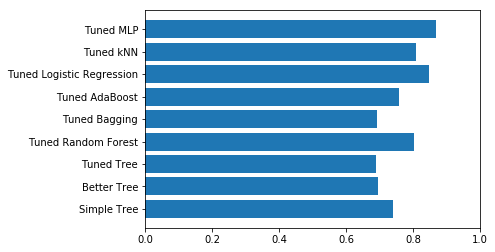

In [62]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.keys()))

In [63]:
display(model_valid_accuracy_comparisons)

{'AdaBoost': 0.61333333333333329,
 'Bagging': 0.72416666666666663,
 'Better Tree': 0.67166666666666663,
 'Logistic Regression': 0.80166666666666664,
 'MLP': 0.83166666666666667,
 'Random Forest': 0.72333333333333338,
 'Simple Tree': 0.70166666666666666,
 'kNN': 0.76000000000000001}

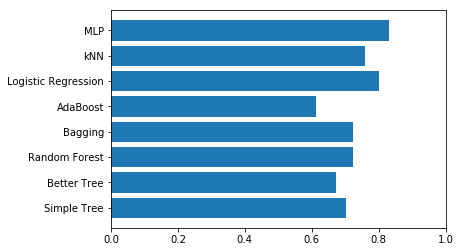

In [64]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_valid_accuracy_comparisons)), list(model_valid_accuracy_comparisons.values()), align='center')
_= plt.yticks(range(len(model_valid_accuracy_comparisons)), list(model_valid_accuracy_comparisons.keys()))

In [65]:
display(model_tuned_params_list)

{'Tuned AdaBoost': {'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=200,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              presort=False, random_state=None, splitter='best'),
  'n_estimators': 150},
 'Tuned Bagging': {'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=200,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              presort=False, random_state=None, splitter='best'),
  'n_estimators': 300},
 'Tuned Logistic Regression': {'C': 0.4,
  'max_iter': 1000,
  'multi_class': 'ovr',
  'solver': 'liblinear'},
 'Tuned MLP': {'alpha': 1.0000000000000001e-05, 'hidden_layer_sizes': 400},
 'Tuned Random Forest': {'max_features': 8,


### Test Best Model On Test Dataset

In [66]:
test_dataset = pd.read_csv('fashion-mnist_test.csv')
test_dataset.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
test_X = test_dataset[test_dataset.columns[1:]]
test_Y = np.array(test_dataset["label"])

In [68]:
test_X = test_X/255

In [69]:
my_model = linear_model.LogisticRegression(C=0.4,max_iter = 1000,multi_class='ovr',solver='liblinear')
my_model = my_model.fit(X,Y)

In [70]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(test_X)

# Print performance details
accuracy = metrics.accuracy_score(test_Y, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(test_Y, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(test_Y), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8597
             precision    recall  f1-score   support

          0       0.82      0.82      0.82      1000
          1       0.97      0.98      0.97      1000
          2       0.84      0.72      0.77      1000
          3       0.91      0.84      0.87      1000
          4       0.76      0.82      0.79      1000
          5       0.95      0.89      0.92      1000
          6       0.63      0.70      0.67      1000
          7       0.90      0.92      0.91      1000
          8       0.94      0.96      0.95      1000
          9       0.91      0.95      0.93      1000

avg / total       0.86      0.86      0.86     10000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,818,4,15,22,0,1,123,0,16,1,1000
1,3,978,0,10,2,1,6,0,0,0,1000
2,12,0,716,9,138,0,114,0,11,0,1000
3,27,25,13,843,40,0,48,0,4,0,1000
4,1,0,43,28,821,0,103,0,4,0,1000
5,2,1,0,0,0,894,0,57,8,38,1000
6,129,3,60,14,74,0,704,0,15,1,1000
7,0,0,0,0,0,33,0,915,0,52,1000
8,3,0,5,3,2,5,17,7,957,1,1000
